# Tissue Affine Registration

## Notebook Purpose

This notebook aims to begin the tissue registration process with affine registration. It allows to easily apply more complex warp-like techniques later in the pipeline. This part of workflow includes creation of bior6.8 pyramid for each tissue image and multi-step affine registration process.

## Imports

### Overview

- PyWavelets (pywt): Bior6.8 wavelet transform for pyramid.
- OpenCV (cv2): Registration algorithm and image processing.
- scikit-image: deconvolution and registration metrics.
- Optuna: Optimalization of registration parameters.

In [ ]:
import pickle
from mimorph import Slide, Tissue
import cv2
import numpy as np
import pywt
from skimage.color import hed2rgb
from skimage.metrics import structural_similarity as ssim
from pathlib import Path
import pickle
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import json
from datetime import datetime
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
import optuna
from optuna.samplers import RandomSampler, NSGAIISampler

## Data import

In [ ]:
load_path = Path('../data/')
to_load = ['slide_1.pkl', 'slide_2.pkl']
slides = []

for file_path in load_path.glob('*.pkl'):
    if file_path.name in to_load:
        with open(file_path, 'rb') as f:
            print(f'Loading {file_path}...')
            obj = pickle.load(f)
            slides.append(obj)


Loading ..\data\slide_1.pkl...
Loading ..\data\slide_2.pkl...


## Bior6.8 adaptive pyramid

Bior6.8 biorthogonal wavelet transformation allows to filter-out insignificant keypoints from registration by preforming it in multiple steps. This wavelet performs really well on bio textures by keeping high contrast of complex organic shapes

In [3]:
bior_he = []
masks = []

def he_bior_pyramid(tissue, levels):
    def normalize(cA, mask, ref_max, ref_min):
        cA = (cA - cA.min()) / (cA.max() - cA.min() + 1e-12)
        cA = np.clip(cA - np.median(cA[~mask]), 0, 1)
        cA = (cA * (ref_max - ref_min) + ref_min).astype(np.uint8)
        return cA
    
    bior = [tissue.he]
    masks = [tissue.mask]

    hem_ref_max, hem_ref_min = tissue.hem.max(), tissue.hem.min()
    eos_ref_max, eos_ref_min = tissue.eos.max(), tissue.eos.min()

    for i in range(levels-1):
        cur_tissue = bior[i]
        cur_mask = masks[i]

        cA_hem, _ = pywt.dwt2(cur_tissue[...,0], 'bior6.8')
        cA_eos, _ = pywt.dwt2(cur_tissue[...,1], 'bior6.8')
        new_mask = cv2.resize(
            cur_mask.astype(np.uint8),
            (cA_hem.shape[1], cA_hem.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

        cA_hem = normalize(cA_hem, new_mask, hem_ref_max, hem_ref_min)
        cA_eos = normalize(cA_eos, new_mask, eos_ref_max, eos_ref_min)

        bior.append(np.stack([cA_hem, cA_eos], axis=-1))
        masks.append(new_mask)

    return bior, masks

for i, slide in enumerate(slides):
    bior_he.append([])
    masks.append([])
    for j, tissue in enumerate(slide):
        bior, mask = he_bior_pyramid(tissue, levels=5)
        bior_he[i].append(bior)
        masks[i].append(mask)

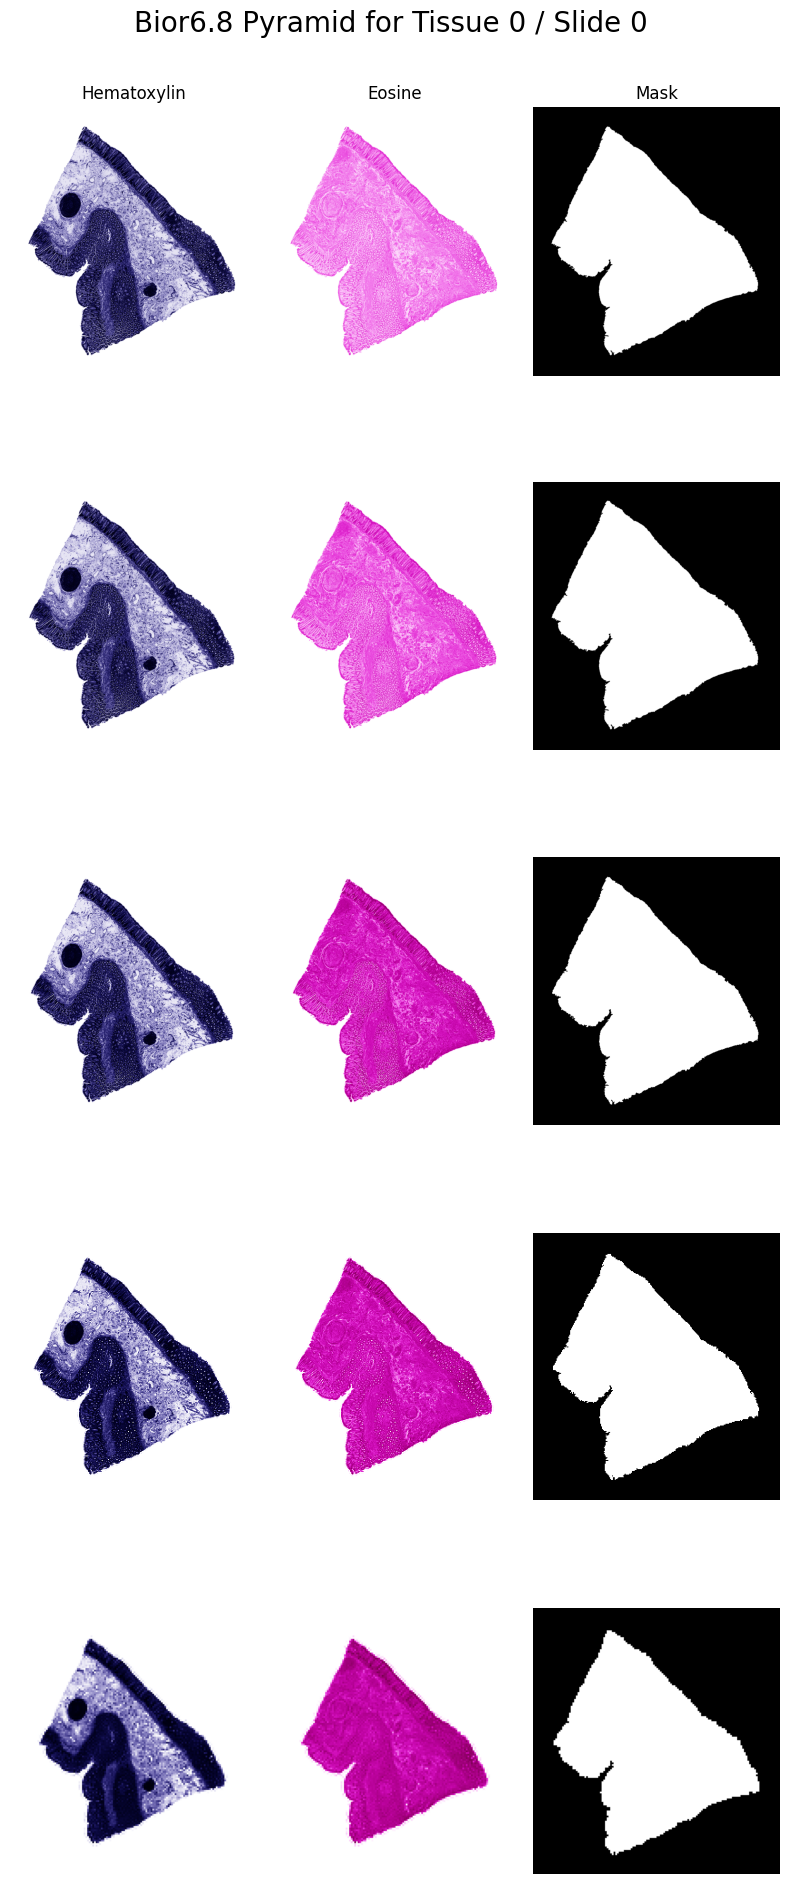

In [4]:
slide_vis_index = 0
tissue_vis_index = 0

def he_rgb(he):
    null = np.zeros_like(he[:, :, 0])
    hem_rgb = hed2rgb(np.stack((he[:, :, 0], null, null), axis=-1))
    eos_rgb = hed2rgb(np.stack((null, he[:, :, 1], null), axis=-1))

    return hem_rgb, eos_rgb

vis, vis_mask = bior_he[slide_vis_index][tissue_vis_index], masks[slide_vis_index][tissue_vis_index]
fig, axes = plt.subplots(len(vis), 3, figsize=(8, len(vis)*4))
fig.suptitle(f'Bior6.8 Pyramid for Tissue {tissue_vis_index} / Slide {slide_vis_index} ',fontsize=20)
for i, (bior, mask) in enumerate(zip(vis, vis_mask)):
    for ax in axes[i]:
        ax.axis('off')
    
    if i == 0:
        axes[i,0].set_title('Hematoxylin')
        axes[i,1].set_title('Eosine')
        axes[i,2].set_title('Mask')

    hem_rgb, eos_rgb = he_rgb(bior)
    axes[i,0].imshow(hem_rgb)
    axes[i,1].imshow(eos_rgb)
    axes[i,2].imshow(mask, cmap='gray')

plt.tight_layout()
plt.show()

**Figure:** Comparison of different pyramid levels of raw Bior6.8 transformation. The organic shape-preserving property can be observed as the decomposition becomes smoother at coarser levels, while maintaining the overall geometry and essential structural details.

## Registration

### Overview

To register the images, we apply a multiscale, feature-based approach. The process begins with decomposing the inputs into pyramid levels, followed by feature detection, matching, and filtering, and is concluded with the estimation of a transformation matrix. The following paragraphs outline each of these steps in more detail.

### Helper Functions

`scale_kp` - scales keypoints for higher resolution of image.
`merge_matches` - combines two sets of keypoint matches, adjusting their indices appropriately and concatenating them into a single list.

In [5]:
def scale_kp(kp: list[cv2.KeyPoint], scale: float) -> list[cv2.KeyPoint]:
    scaled_kp = []
    for k in kp:
        new_k = cv2.KeyPoint(k.pt[0] * scale, k.pt[1] * scale, k.size * scale, k.angle, k.response, k.octave, k.class_id)
        scaled_kp.append(new_k)
    return scaled_kp

def merge_matches(match1: list[cv2.DMatch], match2: list[cv2.DMatch], q_offset: int, t_offset: int):
    assert q_offset >= 0 and t_offset >= 0

    adjusted_match2 = [
        cv2.DMatch(m.queryIdx + q_offset, m.trainIdx + t_offset, m.distance)
        for m in match2
    ]

    return match1 + adjusted_match2

### Key-points calculation

Key points are calculated using selected feature in the tissue area. Subsequently scaling is performed and keypoints are returned.

In [6]:
def find_scaled(
        feature: cv2.Feature2D,
        o_img1: np.ndarray, img1: np.ndarray, mask1: np.ndarray, 
        o_img2: np.ndarray, img2: np.ndarray, mask2: np.ndarray,
        return_params=False
    ):
    
    params = None

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))

    mask1 = cv2.dilate(mask1.astype(np.uint8), kernel, iterations=1).astype(bool)
    mask2 = cv2.dilate(mask2.astype(np.uint8), kernel, iterations=1).astype(bool)

    kp1, des1 = feature.detectAndCompute(img1, mask1.astype(np.uint8))
    kp2, des2 = feature.detectAndCompute(img2, mask2.astype(np.uint8))
    
    img1_scale = o_img1.shape[0] / img1.shape[0]
    img2_scale = o_img2.shape[0] / img2.shape[0]
    
    kp1 = scale_kp(kp1, img1_scale)
    kp2 = scale_kp(kp2, img2_scale)
    
    if return_params:
        params = {
            'kp1': kp1,
            'kp2': kp2,
            'des1': des1,
            'des2': des2,
        }

    return kp1, des1, kp2, des2, params

### Key-points and Matches Filtering

This part covers techniques used to filter matches and keypoints to separate information useful for registration from noise, irrelevant correspondences, and spurious detections.

#### Lowe's test

Lowe's test is used to discard ambiguous matches by comparing the best match with the second-best alternative and keeping only those with sufficient distinctiveness. It allows for simple filtering, reducing the complexity of registration.

In [7]:
def lowes_test_ratio(matches: list[cv2.DMatch], ratio: float = 0.75) -> list[cv2.DMatch]:
    good_matches = []
    for match in matches:
        if len(match) == 2:
            m, n = match
            if m.distance < ratio * n.distance:
                good_matches.append(m)
    return good_matches

def filter_mask(kp: list[cv2.KeyPoint], mask: np.ndarray) -> list[cv2.KeyPoint]:
    filtered_kp = []
    for k in kp:
        if mask[int(k.pt[1]), int(k.pt[0])]:
            filtered_kp.append(k)
    return filtered_kp

### Mutual matching

Mutual matching filters correspondences by retaining only those keypoint pairs that are consistent in both matching directions. While it may yield worse results for certain cases, it helps maintain the stability of registration when using the same hyperparameters.

In [8]:
def mutual_filter(matcher, des1, des2, good_matches, lowes_ratio=0.75):
    matches_rev = matcher.knnMatch(des2, des1, k=2)
    good_matches_rev = lowes_test_ratio(matches_rev, ratio=lowes_ratio)
    rev_pairs = set((m_rev.trainIdx, m_rev.queryIdx) for m_rev in good_matches_rev)
    filtered_matches = [m for m in good_matches if (m.queryIdx, m.trainIdx) in rev_pairs]
    return filtered_matches

#### Sample by weight

Weight sampling works by assigning a weight to each match based on its reliability or strength, creating a probability distribution from these weights, and then selecting matches according to this distribution. This approach prioritizes more reliable matches while still retaining some diversity, reducing computational load, improving stability in the registration process and generalization during hyperparameter optimalization.

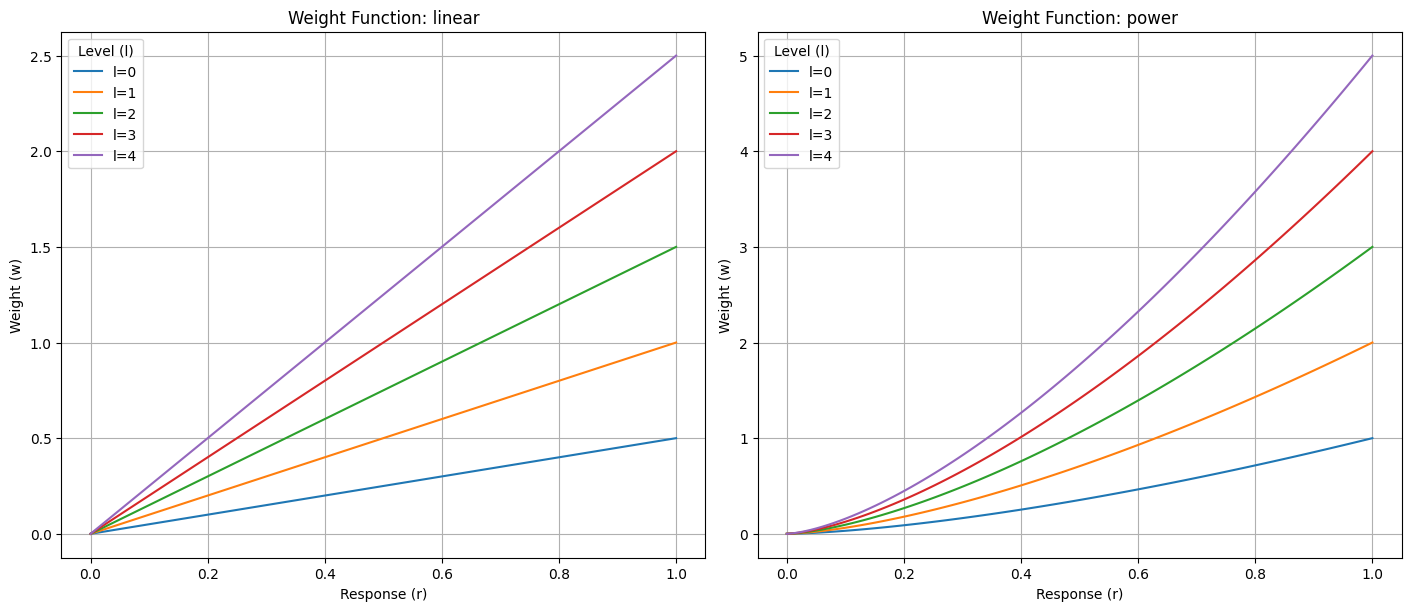

In [9]:
def power(l, r1, r2):
    r = (r1 + r2) / 2
    return (l + 1) * (r ** 1.5) + 1e-6

def linear(l, r1, r2):
    r = (r1 + r2) / 2
    return (l + 1) * r / 2 + 1e-6

w_function = {
    'linear': linear,
    'power' : power 
}

def sample_matches(
        matches: list[cv2.DMatch], 
        kp1: list[cv2.KeyPoint], kp2: list[cv2.KeyPoint], 
        des1: list, des2: list,
        weights: np.ndarray[np.float32],
        sample_prc: float = 0.2,
        seed: int = 42,
        verbose: int = 0,
        return_params=False
    ):


    params = None
    if return_params:
        params = {}

    assert len(weights) == len(matches)
    
    if verbose >= 1:
        print(f'Total matches: {len(matches)}')
        print(f'Sampling {sample_prc*100:.1f}% of matches')
    
    np.random.seed(seed)
    w_min = weights.min()
    w_max = weights.max()
    if w_max == w_min:
        w_norm = np.ones_like(weights) / len(weights)
    else:
        w_norm = (weights - w_min) / (w_max - w_min)
        w_norm = w_norm / w_norm.sum()
    
    indexes = np.arange(len(weights))
    choice = np.random.choice(indexes, size=int(len(weights) * sample_prc), p=w_norm, replace=False)
    
    if verbose >= 1:
        print(f'Selected {len(choice)} matches after weighted sampling')
    
    ret_kp1 = []
    ret_kp2 = []
    ret_des1 = []
    ret_des2 = []
    ret_matches = []
    for i, c in enumerate(choice):
        q_idx = matches[c].queryIdx
        t_idx = matches[c].trainIdx
        
        ret_matches.append(matches[c])
        ret_kp1.append(kp1[q_idx])
        ret_kp2.append(kp2[t_idx])
        ret_des1.append(des1[q_idx])
        ret_des2.append(des2[t_idx])
        ret_matches[i].queryIdx = i
        ret_matches[i].trainIdx = i

    if verbose >= 1:
        print(f'Returned {len(ret_matches)} sampled matches')
    
    if return_params:
        params['sampled'] = ret_matches
        not_selected = list(set(np.arange(len(weights))) - set(choice))

        ret_matches_not = []
        ret_kp1_not = []
        ret_kp2_not = []
        ret_des1_not = []
        ret_des2_not = []

        for c in not_selected:
            q_idx = matches[c].queryIdx
            t_idx = matches[c].trainIdx

            ret_matches_not.append(matches[c])
            ret_kp1_not.append(kp1[q_idx])
            ret_kp2_not.append(kp2[t_idx])
            ret_des1_not.append(des1[q_idx])
            ret_des2_not.append(des2[t_idx])

        params['not_sampled'] = ret_matches_not

    return ret_matches, (ret_kp1, ret_des1), (ret_kp2, ret_des2), params


r = np.linspace(0, 1, 100)
levels = [0, 1, 2, 3, 4]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

for ax, (name, func) in zip(axs, w_function.items()):
    for l in levels:
        w = func(l, r, r)
        ax.plot(r, w, label=f'l={l}')
    ax.set_title(f'Weight Function: {name}')
    ax.set_xlabel('Response (r)')
    ax.set_ylabel('Weight (w)')
    ax.legend(title='Level (l)')
    ax.grid(True)

plt.show()

**Figure** visualisation of diffrent weight functions.

In [10]:
def filter_keypoints_and_matches(
    matcher, des1, des2, 
    lowes_ratio=0.75, mutual=False,
    verbose=0,
    return_params=False
):
    
    params = None
    if return_params:
        params = {
            'total': 0,
            'filtered': 0
        }

    if des1 is None or des2 is None:
        return [], params

    matches = matcher.knnMatch(des1, des2, k=2)
    
    if return_params:
        params['total'] = len(matches)

    if verbose >= 1:
        print(f'Matches before filtering: {len(matches)}')
    
    good_matches = lowes_test_ratio(matches, ratio=lowes_ratio)
    
    if verbose >= 2:
        print(f"Matches after Lowe's ratio test: {len(good_matches)}")
    
    if mutual:
        if verbose >= 2:
            print('Performing mutual filtering...')
        good_matches = mutual_filter(matcher, des1, des2, good_matches, lowes_ratio)
    
    if verbose >= 1:
        print(f'Matches after filtering: {len(good_matches)}')

    if return_params:
        params['filtered'] = len(good_matches)

    return good_matches, params

### Matching

This step combines:
- Keypoint calculation
- Filtering
- Sampling

Containing whole matching part of registration into function: `match_find_bior`.

In [11]:
def match_find_bior(
        feature: cv2.Feature2D, matcher: cv2.DescriptorMatcher,
        bior1_pyr: list[np.ndarray], bior2_pyr: list[np.ndarray],
        bior1_mask: list[np.ndarray], bior2_mask: list[np.ndarray],
        levels: list[int] = [0],
        mutual: bool = False,
        lowes_ratio: float = 0.75,
        weight_function: callable = None,
        sample_prc: float = 0.2,
        random_seed: int = 42,
        verbose:int = 0,
        return_params=False
    ):
    
    weights = []
    ret_matches = []
    ret_kp1, ret_des1 = [], []
    ret_kp2, ret_des2 = [], []
    
    level_kp_des_params = None
    level_match_params = None
    if return_params:
        level_kp_des_params = []
        level_match_params = []

    for l in sorted(levels, reverse=True):
        if verbose >= 1:
            print(f'Processing level {l}')
        kp1, des1, kp2, des2, kp_des_params = find_scaled(
            feature, 
            bior1_pyr[0], bior1_pyr[l], bior1_mask[l], 
            bior2_pyr[0], bior2_pyr[l], bior2_mask[l],
            return_params=return_params
        )
        if return_params:
            kp_des_params['level'] = l
            level_kp_des_params.append(kp_des_params)
        
        matches, match_params = filter_keypoints_and_matches(
            matcher, des1, des2,
            lowes_ratio, mutual,
            verbose,
            return_params=return_params
        )
        if return_params:
            match_params['level'] = l
            level_match_params.append(match_params)
        
        loc_weights = None
        if weight_function is not None:
            loc_weights = [weight_function(l, kp1[m.queryIdx].response, kp2[m.trainIdx].response) for m in matches]
            weights.extend(loc_weights)

        ret_matches = merge_matches(ret_matches, matches, len(ret_kp1), len(ret_kp2))
        
        ret_kp1.extend(kp1)
        ret_kp2.extend(kp2)
        ret_des1.extend(des1)
        ret_des2.extend(des2)

    params = None
    if return_params:
        params = {
            'match': level_match_params,
            'kp_des': level_kp_des_params
        }

    if weight_function is not None:
        ret_matches, (ret_kp1, ret_des1), (ret_kp2, ret_des2), sample_params = sample_matches(
            ret_matches, 
            ret_kp1, ret_kp2,
            ret_des1, ret_des2,
            np.array(weights), 
            sample_prc, random_seed,
            verbose=verbose,
            return_params=return_params
        )
        params['sample'] = sample_params

    return ret_matches, (ret_kp1, ret_des1), (ret_kp2, ret_des2), params

### Homography

The entire process is consolidated into a single function, which includes tissue preparation, image matching through a defined pipeline, and homography estimation using the RANSAC method to robustly handle outliers.

In [12]:
def find_homography_he_bior(
        bior_he1, bior_he2,
        bior_mask1, bior_mask2,
        feature: cv2.Feature2D,
        matcher: cv2.DescriptorMatcher,
        
        levels: list[int] = [0],
        verbose:int = 0,

        filter__mutual: bool = False,
        filter__lowes_ratio: float = 0.75,
        filter__weight_function: callable = None,
        filter__sample_prc: float = 0.2,
        filter__random_seed: int = 42,

        homography__ransacReprojThreshold=4.0,
        homography__refineIters=10,

        return__params=False
    ):

    get_ch = lambda bior, ch: [bior[i][...,ch] for i in range(len(bior))]

    bior_hem1 = get_ch(bior_he1, 0)
    bior_hem2 = get_ch(bior_he2, 0)
    bior_eos1 = get_ch(bior_he1, 1)
    bior_eos2 =  get_ch(bior_he2, 1)

    bior_channels = [(bior_hem1, bior_hem2), (bior_eos1, bior_eos2)]
    
    matches = []
    kp1 = []
    kp2 = []
    
    q_offset = 0
    t_offset = 0

    params = None
    channels = ['hem', 'eos']
    if return__params:
        params = {}

    for i, (ch1, ch2) in enumerate(bior_channels):
        ch_matches, (ch_kp1, _), (ch_kp2, _), ch_params = match_find_bior(
            feature, matcher,
            ch1, ch2,
            bior_mask1, bior_mask2,
            
            levels=             levels,
            verbose=            verbose,
            mutual=             filter__mutual,
            lowes_ratio=        filter__lowes_ratio,
            weight_function=    filter__weight_function,
            sample_prc=         filter__sample_prc,
            random_seed=        filter__random_seed,

            return_params=      return__params
        )

        if return__params:
            params[channels[i]] = ch_params

        if i == 0:
            q_offset += len(ch_kp1)
            t_offset += len(ch_kp2)

        kp1.extend(ch_kp1)
        kp2.extend(ch_kp2)
        matches.append(ch_matches)

    matches = merge_matches(matches[0], matches[1], q_offset, t_offset)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.estimateAffinePartial2D(
        src_pts, dst_pts,

        method=                 cv2.RANSAC, 
        ransacReprojThreshold=  homography__ransacReprojThreshold,
        refineIters=            homography__refineIters
    )
    if H is None:
        raise ValueError("Affine matrix is not valid")

    if return__params:
        mask = mask.ravel().astype(bool)
        inlier_matches = [m for i, m in enumerate(matches) if mask[i]]

        params['ransac'] = {'inline':inlier_matches}

        return H, params
    
    return H

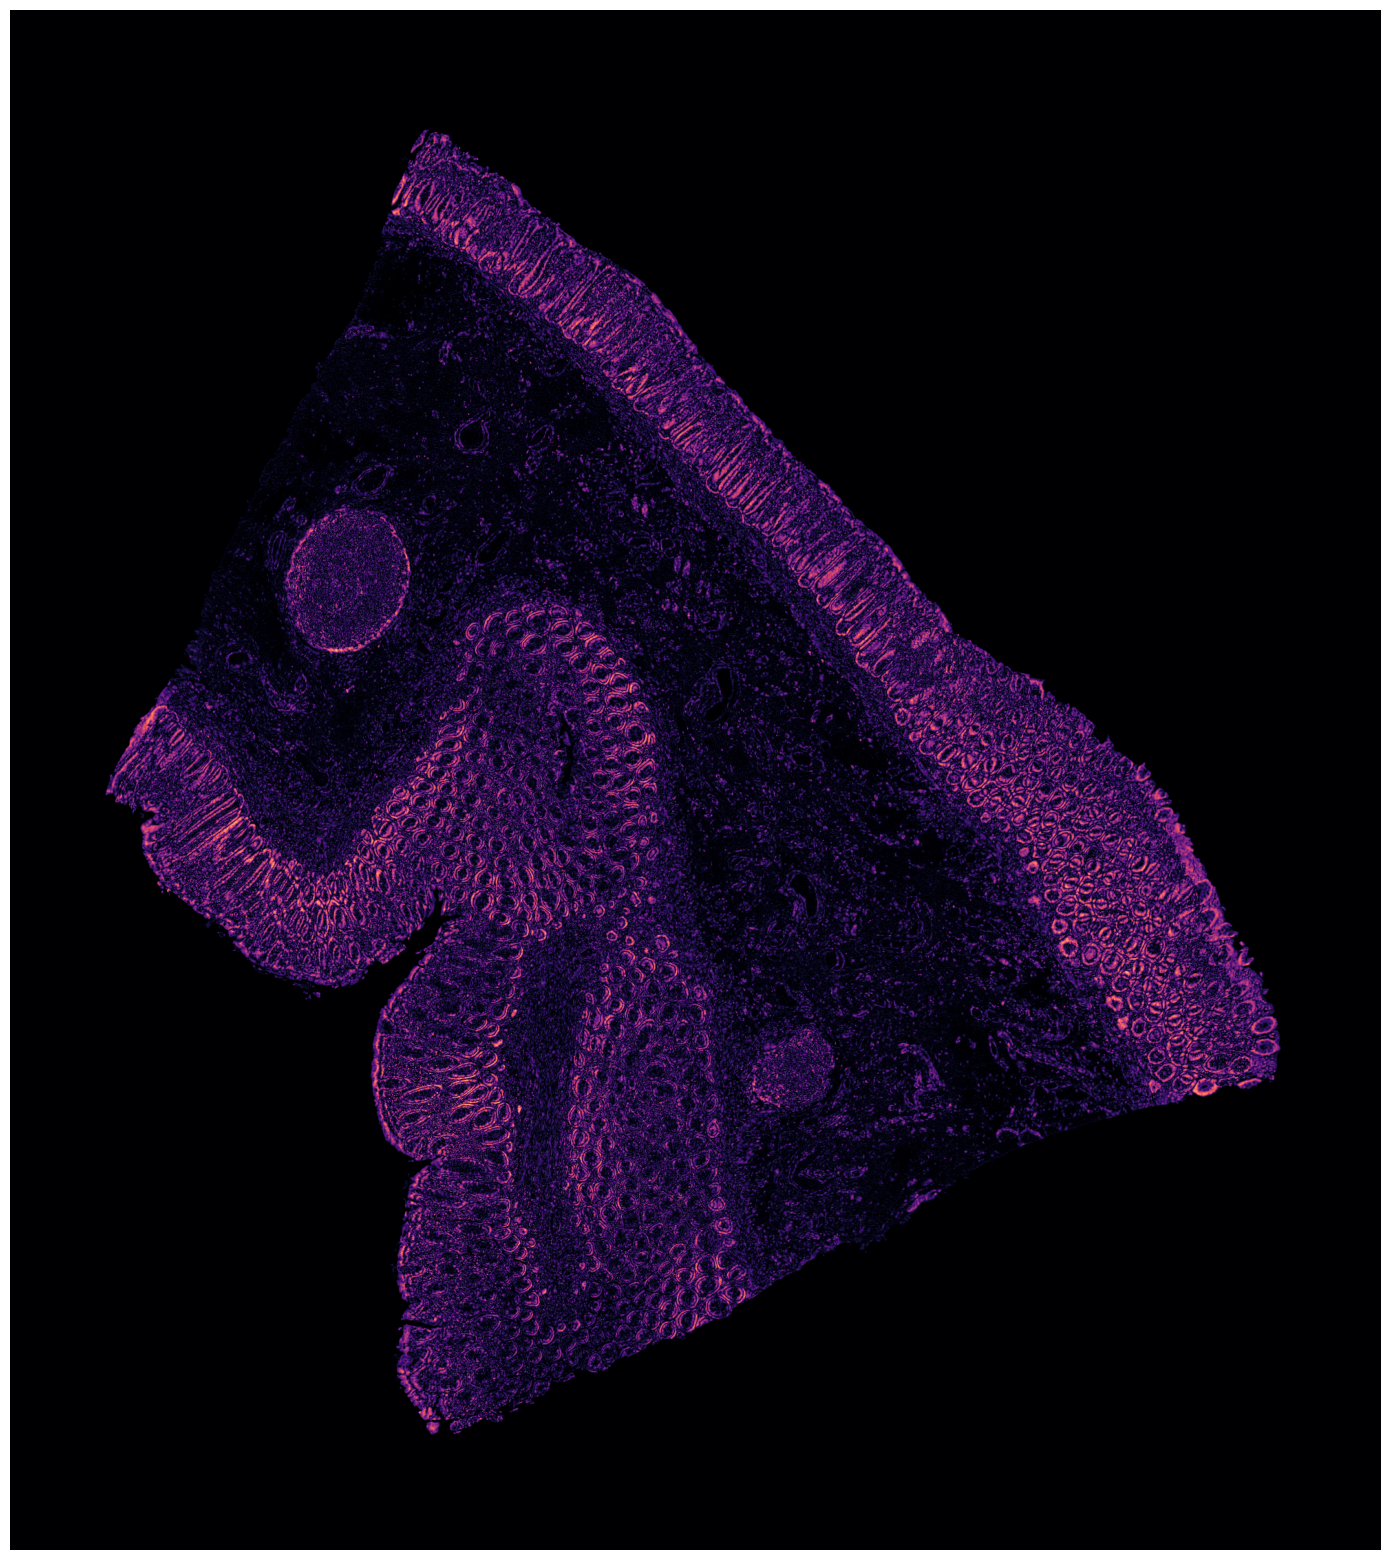

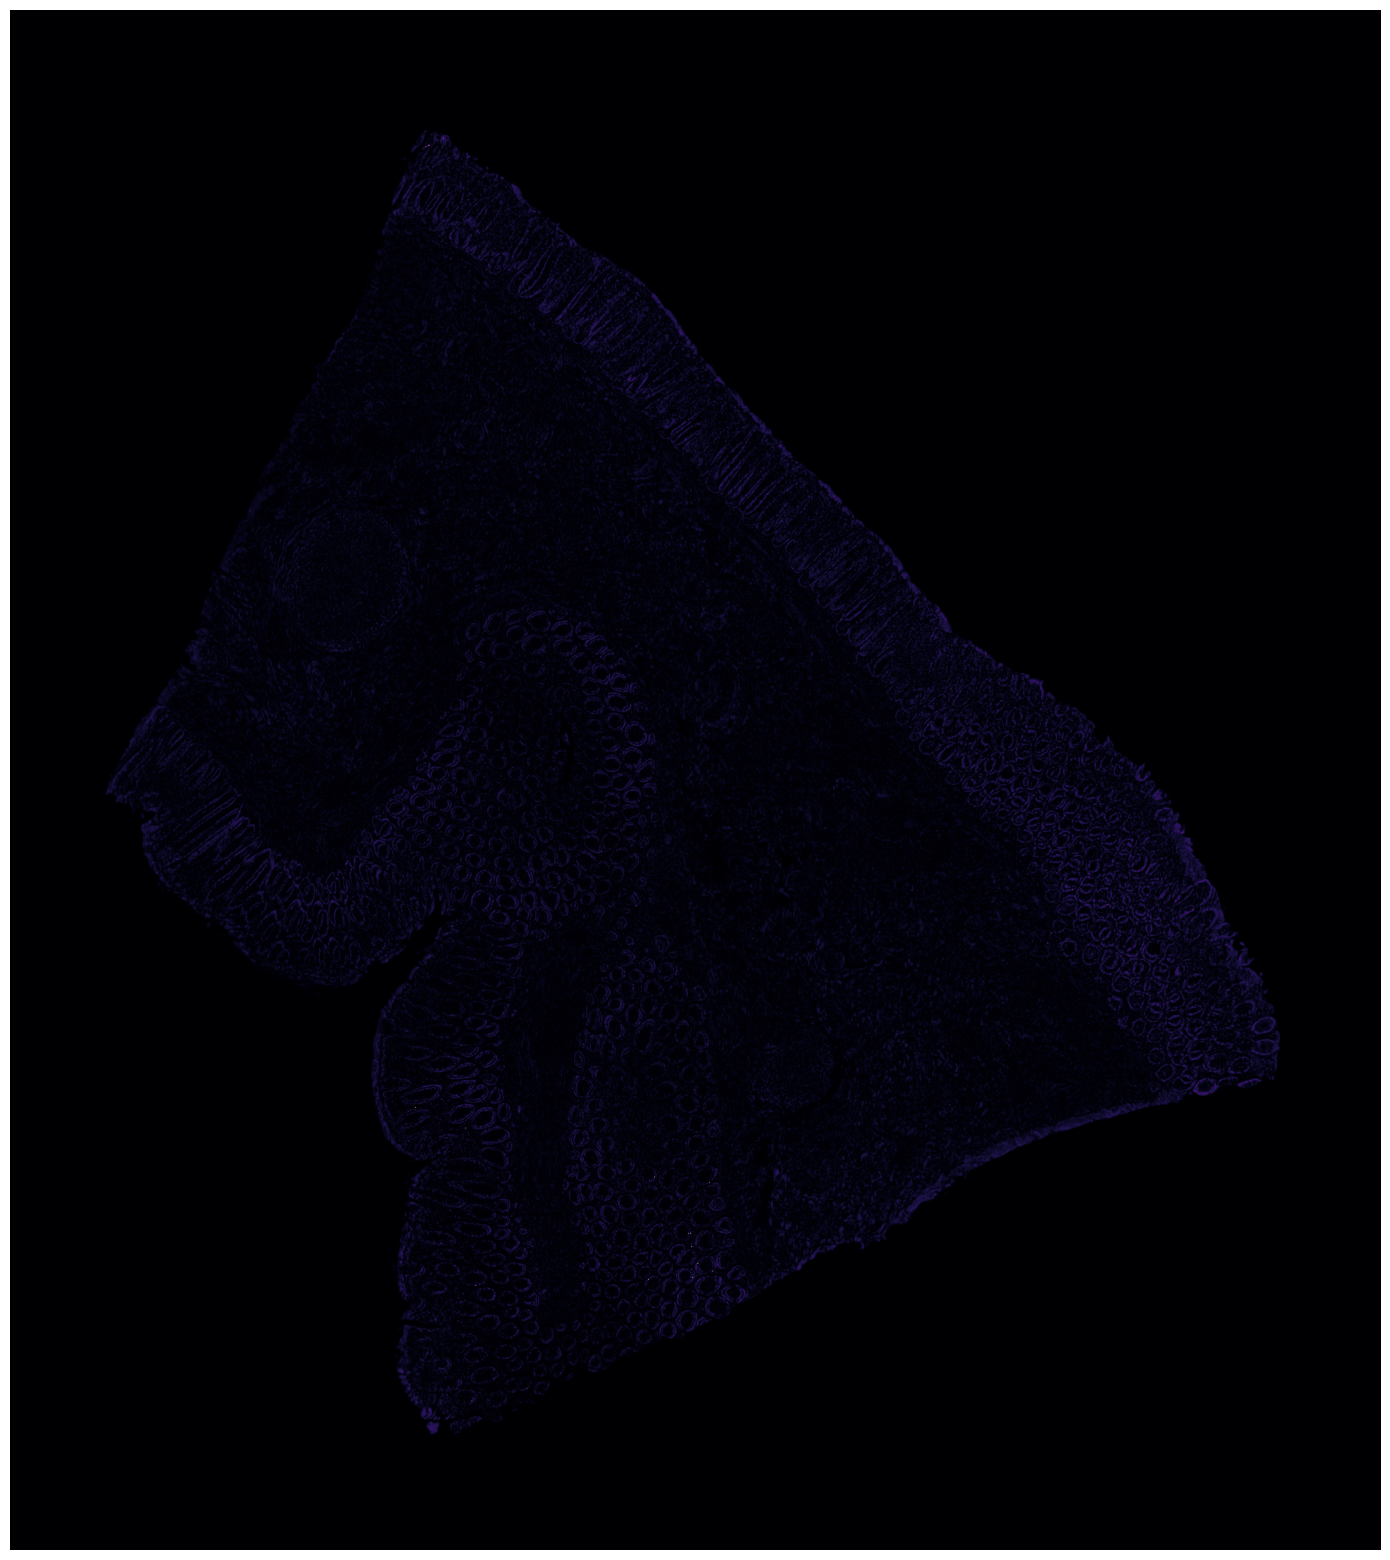

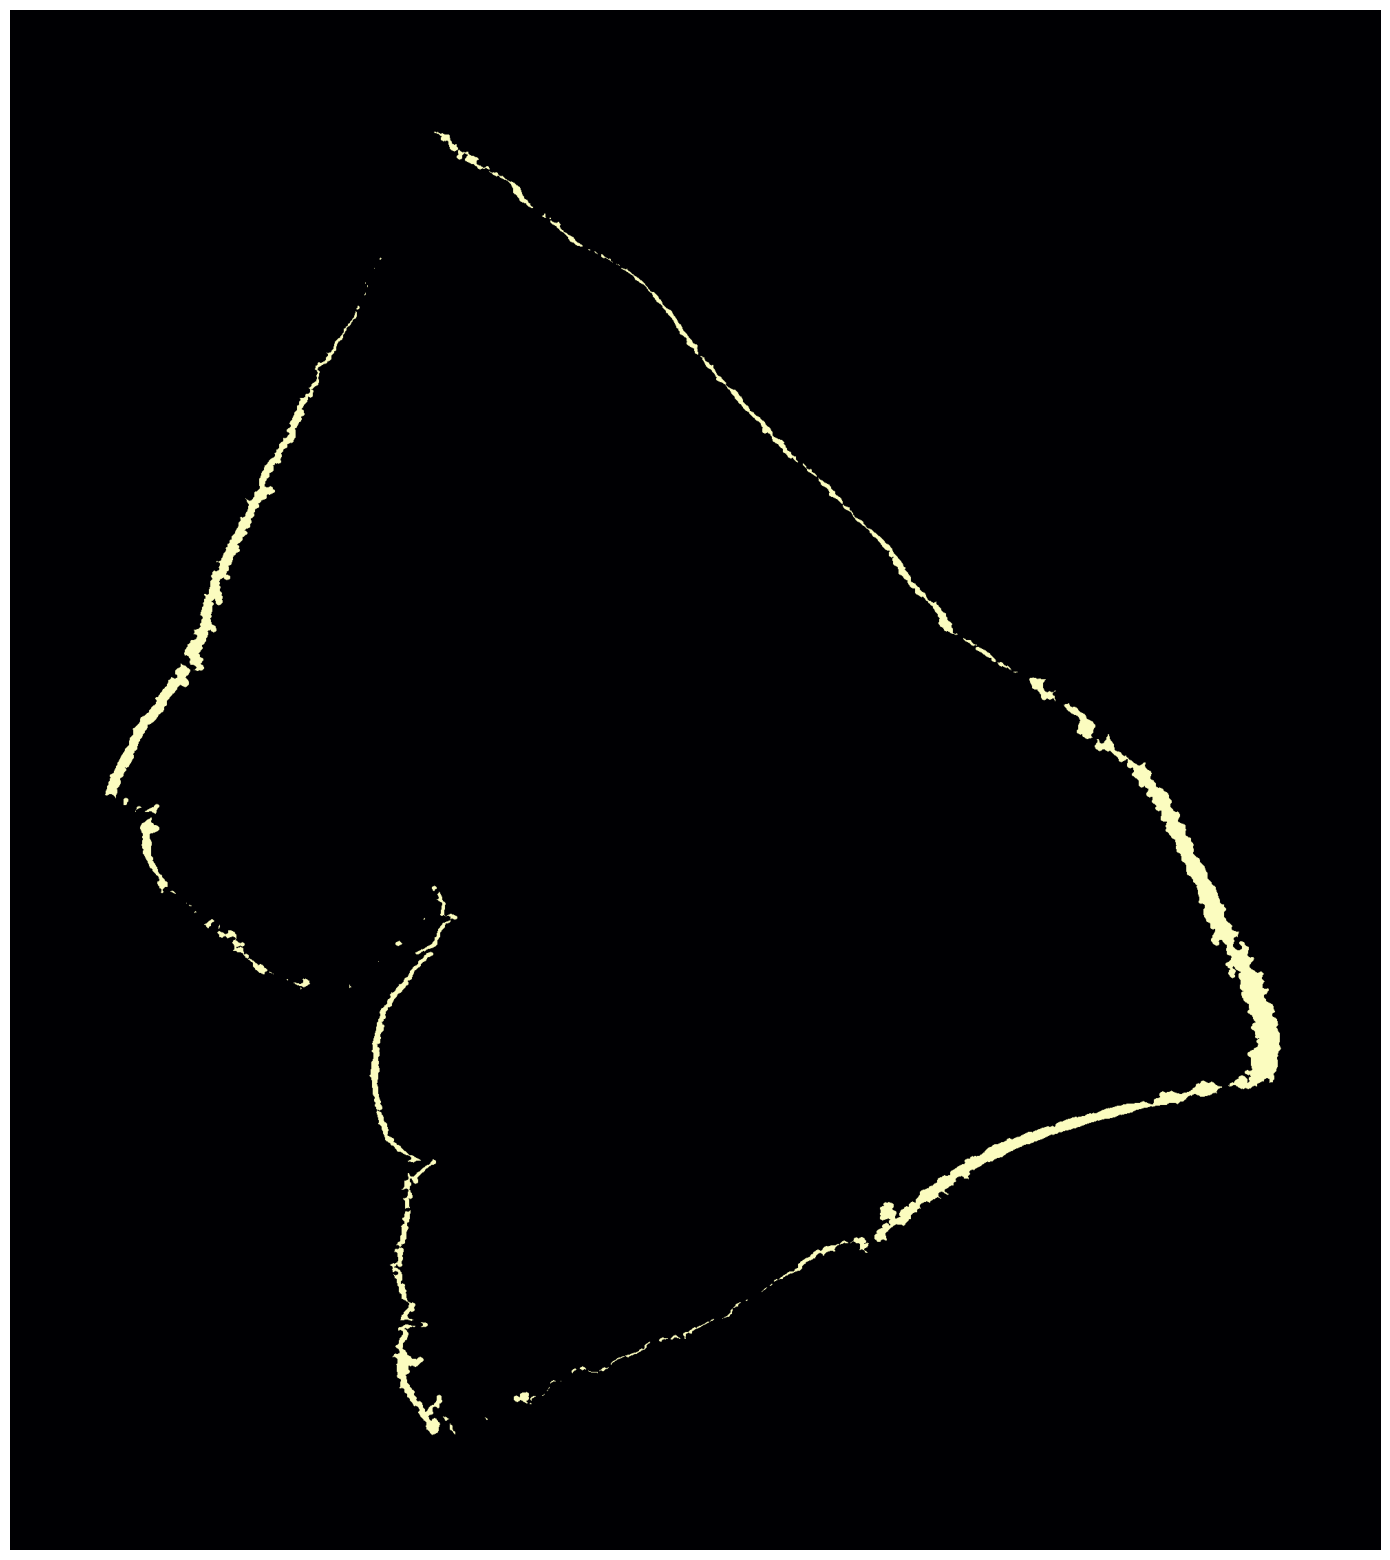

In [13]:
slide_vis_index = 0
tissue_vis_index1 = 0
tissue_vis_index2 = 1

bior_he1 = bior_he[slide_vis_index][tissue_vis_index1]
bior_he2 = bior_he[slide_vis_index][tissue_vis_index2]

mask1 = masks[slide_vis_index][tissue_vis_index1]
mask2 = masks[slide_vis_index][tissue_vis_index2]


H, params = find_homography_he_bior(
    bior_he1, bior_he2, 
    mask1, mask2, 
    feature = cv2.KAZE_create(
        upright=                False,
        threshold=              0.001, 
        nOctaves=               4, 
        nOctaveLayers=          4,
        diffusivity=            cv2.KAZE_DIFF_PM_G2
    ),
    matcher = cv2.FlannBasedMatcher(
        dict(
            algorithm=1, trees=5
        ),
        dict(
            checks=50
        )
    ),

    levels =                    [0, 1, 2, 3, 4],
    verbose =                   0,

    filter__mutual =            False,
    filter__lowes_ratio =       0.75,
    filter__weight_function =   w_function['power'],
    filter__sample_prc =        0.8,
    filter__random_seed =       42,

    homography__ransacReprojThreshold=4.0,
    homography__refineIters=    10,

    return__params=            True,
)

tissue1 = slides[slide_vis_index][tissue_vis_index1]
tissue2 = slides[slide_vis_index][tissue_vis_index2]

warp = lambda ch, H, shape: cv2.warpAffine(
    ch, H, (shape[1], shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
)

vis_hem = warp(tissue1.hem, H, tissue2.hem.shape)
vis_eos = warp(tissue1.eos, H, tissue2.eos.shape)
h_mask1 = warp(tissue1.mask.astype(np.uint8), H, tissue2.mask.shape).astype(bool)

vis_hem[~h_mask1] = 0
vis_eos[~h_mask1] = 0

vis_hem2 = tissue2.hem
vis_eos2 = tissue2.eos
vis_hem2[~tissue2.mask] = 0
vis_eos2[~tissue2.mask] = 0


diff_hem = cv2.absdiff(vis_hem2, vis_hem)
diff_eos = cv2.absdiff(vis_eos2, vis_eos)

show = [diff_hem, diff_eos, (h_mask1 & (~tissue2.mask))]

for s in show:
    plt.figure(figsize=(20,20))
    plt.imshow(s, cmap='magma')
    plt.axis('off')
    plt.show()

**Figure:** The first and second images show the differences between the hematoxylin and eosin channels. Areas of yellow-white intensity correspond to higher differences, whereas blue regions indicate lower differences. The final image illustrates the differences between tissue regions (masks).

We can observe that the regions surrounding the cell nuclei exhibit high intensity at their edges, appearing as two bright rings in the image. This indicates the correct alignment of the nuclei at this location, as it reflects the expected reduction in the nuclear cross-section in accordance with the assumptions. 

Another observation is the lower-quality fitting at the tissue boundaries, where the intensity differences are noticeably higher. This effect is caused by the nonlinear shifting and stretching of tissue fragments during sample collection, which will be corrected in the subsequent steps.

## Hyper Parameter Optimalization

In order to achieve accurate tissue registration for various scenarios, it is essential to carefully determine the optimal set of parameters. Hyperoptimization enables a systematic exploration of the parameter space, allowing for the identification of configurations that maximize alignment quality while minimizing distortions.

### Metric

The following function defines a composite metric used to evaluate the quality of tissue registration. It combines complementary similarity measures—mean squared error (MSE), normalized gradient fields (NGF), and structural similarity index (SSIM)—applied across both channels of the tissue images. This multi-metric approach provides a more robust assessment of alignment accuracy by capturing both intensity- and structure-based differences.

In [ ]:
def _mutual_information(img1: np.ndarray, img2: np.ndarray, bins: int = 256) -> float:
    hist_2d, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=bins)
    pxy = hist_2d / np.sum(hist_2d)
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = np.outer(px, py)
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def old_metric(params: dict,
           tissue1: np.ndarray,
           tissue2: np.ndarray,
           w: dict) -> tuple[float, dict]:

    matches = params['hem']['match'] + params['eos']['match']
    total_all    = sum(m['total']    for m in matches)
    filtered_all = sum(m['filtered'] for m in matches)
    alpha = filtered_all / total_all if total_all > 0 else 0.0

    if 'sample' in params.get('hem', {}) and 'sample' in params.get('eos', {}):
        sampled = len(params['hem']['sample']['sampled'] + params['eos']['sample']['sampled'])
        not_sampled = len(params['hem']['sample']['not_sampled'] + params['eos']['sample']['not_sampled'])
        beta = sampled / (sampled + not_sampled) if (sampled + not_sampled) > 0 else 0.0
    else:
        beta = 1.0

    inliers = len(params.get('ransac', {}).get('inline', []))
    gamma = inliers / filtered_all if filtered_all > 0 else 0.0

    hem1, eos1 = tissue1[..., 0], tissue1[..., 1]
    hem2, eos2 = tissue2[..., 0], tissue2[..., 1]

    ssim_hem = ssim(hem1, hem2, data_range=hem2.max() - hem2.min())
    ssim_eos = ssim(eos1, eos2, data_range=eos2.max() - eos2.min())

    mi_hem = _mutual_information(hem1, hem2)
    mi_eos = _mutual_information(eos1, eos2)
    mi_val = 0.5 * (mi_hem + mi_eos)

    stacked1 = np.stack([hem1, eos1], axis=-1)
    stacked2 = np.stack([hem2, eos2], axis=-1)
    psnr_val = cv2.PSNR(stacked1, stacked2)

    psnr_norm = min(psnr_val / 50.0, 1.0)
    mi_norm = min(mi_val / w.get('mi_max', 2.0), 1.0)

    quality = (
        w['ssim_hem'] * ssim_hem +
        w['ssim_eos'] * ssim_eos +
        w['mi']       * mi_norm +
        w['psnr']     * psnr_norm
    )

    confidence = (
        w['gamma'] * min(gamma, 1.0) +
        w['alpha'] * min(alpha, 1.0) +
        w['beta']  * min(beta, 1.0)
    )

    score = quality * np.log1p(confidence)

    details = {
        'RANSAC inliers' : gamma,
        'filtered/total' : alpha,
        'match ratio'    : beta,
        'HEM SSIM'           : ssim_hem,
        'EOS SSIM'           : ssim_eos,
        'MI norm'            : mi_norm,
        'PSNR norm'          : psnr_norm,
        'confidence_sum'     : confidence,
    }

    return score, details

def metric(params: dict,
           tissue1: np.ndarray,
           tissue2: np.ndarray
    ):

    def NGF(i1, i2, epsilon=1e-6):
        def grad(i):
            gx = cv2.Sobel(i, cv2.CV_64F, 1, 0, ksize=3)
            gy = cv2.Sobel(i, cv2.CV_64F, 0, 1, ksize=3)
            g = np.stack((gx, gy), axis=-1)
            norm = np.sqrt(np.sum(g**2, axis=-1, keepdims=True) + epsilon**2)
            return g / norm
        n1 = grad(i1)
        n2 = grad(i2)
        dp = np.sum(n1 * n2, axis=-1)
        return np.mean(1 - dp**2)
    
    def MSE(i1, i2):
        err = np.square(i1.astype("float") - i2.astype("float"))
        
        return np.mean(err)

    mean_metric = lambda metric, t1, t2: (metric(t1[...,0], t2[...,0]) + metric(t1[...,1], t2[...,1])) / 2

    mse_v = mean_metric(MSE, tissue1, tissue2)
    ngf_v = mean_metric(NGF, tissue1, tissue2)
    ssim_v = mean_metric(ssim, tissue1, tissue2)

    return {'MSE' : mse_v, 'NGF' : ngf_v, 'SSIM' : ssim_v}

The function `plot_score` creates barplot of every metric from the registration process.

(2239, 1992, 2)
(2239, 1992, 2)


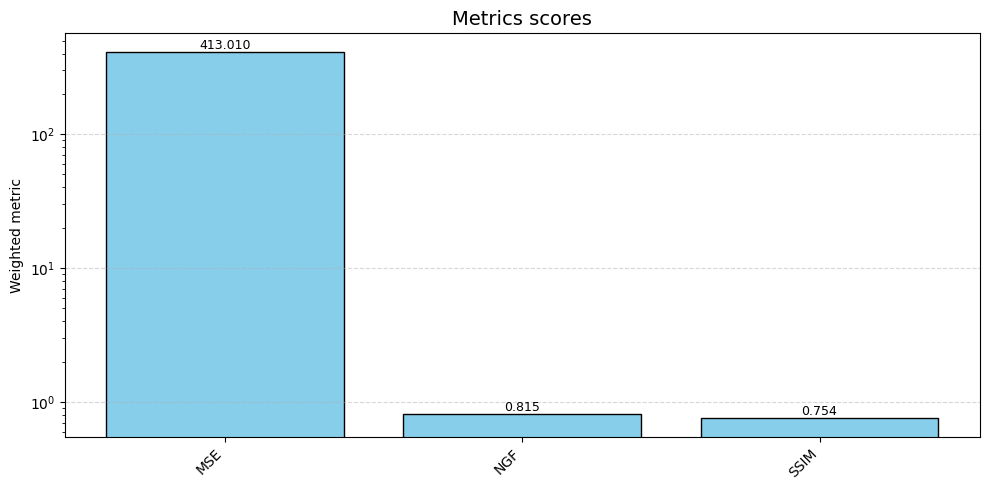

In [15]:
tissue1 = np.dstack((vis_hem, vis_eos))
tissue2 = np.dstack((vis_hem2, vis_eos2))

print(tissue1.shape)
print(tissue2.shape)

scores = metric(
    params, tissue1, tissue2, 
)

metric_count = len(scores)

def plot_score(scores, ax=None):
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_ax = True

    sorted_met = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
    labels = list(sorted_met.keys())
    values = list(sorted_met.values())

    ax.bar(labels, values, color='skyblue', edgecolor='black')
    ax.set_title('Metrics scores', fontsize=14)
    ax.set_ylabel('Weighted metric')
    ax.set_yscale('log')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    for i, val in enumerate(values):
        ax.text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    if created_ax:
        plt.tight_layout()
        plt.show()
    else:
        return ax

plot_score(scores)

**Figure:** The visualisation of barplot created by plotting function based on parameters from our first registration. NGF of 0.815 indicates good alignment of structures and edges between layers. SSIM of 0.754 reflects moderate structural similarity, with local differences in texture and intensity. MSE of 413 (≈RMSE 20, PSNR 22 dB) highlights noticeable pixel-wise differences, as expected for different tissue layers. Overall, geometry is well preserved.

### Metric evaluation

The metrics are evaluated on three examples, each progressively worse than the previous one, to illustrate the sensitivity of the measures to misalignment and structural differences. As the examples degrade, NGF decreases, indicating poorer edge and structure alignment; SSIM drops, reflecting reduced structural similarity; and MSE increases, showing larger pixel-wise discrepancies. This progression highlights how the combined metrics provide a comprehensive assessment of registration quality across both geometry and intensity.

In [16]:
slide_vis_index = 1
tissue_vis_index1 = 2
tissue_vis_index2 = 3

def warp_tissues(tissue1, tissue2, H):
    warp = lambda ch, H, shape: cv2.warpAffine(
        ch, H, (shape[1], shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )

    h_hem = warp(tissue1.hem, H, tissue2.hem.shape)
    h_eos = warp(tissue1.eos, H, tissue2.eos.shape)
    h_mask1 = warp(tissue1.mask.astype(np.uint8), H, tissue2.mask.shape).astype(bool)

    h_hem[~h_mask1] = 0
    h_eos[~h_mask1] = 0

    h_hem2 = tissue2.hem
    h_eos2 = tissue2.eos
    h_hem2[~tissue2.mask] = 0
    h_eos2[~tissue2.mask] = 0
    h_mask2=tissue2.mask
    tissue1 = np.dstack((h_hem, h_eos))
    tissue2 = np.dstack((h_hem2, h_eos2))
    return (tissue1, h_mask1), (tissue2, h_mask2)

def measure_params(
    slide_index,
    tissue1_index,
    tissue2_index,

    hyper_params,
    random_seed = 0
):
    scores = []
    warps = []

    bior1 = bior_he[slide_index][tissue1_index]
    bior2 = bior_he[slide_index][tissue2_index]

    tissue1 = slides[slide_index][tissue1_index]
    tissue2 = slides[slide_index][tissue2_index]

    mask1 = masks[slide_index][tissue1_index]
    mask2 = masks[slide_index][tissue2_index]

    multiple_params = isinstance(hyper_params, list)

    if not multiple_params:
        hyper_params = [hyper_params]


    for hp in hyper_params:
        H, params = find_homography_he_bior(
            bior1, bior2, 
            mask1, mask2, 
            verbose =                           0,
            filter__random_seed =               random_seed,
            return__params=                     True,
            **hp
        )

        (t1, m1), (t2, m2) = warp_tissues(tissue1, tissue2, H)
        s = metric(params, t1, t2)
        scores.append(s)
        warps.append((t1, t2))

    if not multiple_params:
        return scores[0], warps[0]

    return scores, warps

In [17]:
hyper_params = [
    dict(
        feature = cv2.ORB_create(
            nfeatures=1000,
            scaleFactor=1.2,
            nlevels=4,
            edgeThreshold=31,
            firstLevel=0,
            WTA_K=2,
            scoreType=cv2.ORB_HARRIS_SCORE,
            patchSize=15,
            fastThreshold=20
        ),
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False),

        levels = [0],

        filter__mutual = False,
        filter__lowes_ratio = 0.6,
        filter__weight_function = None,
        filter__sample_prc = 1,

        homography__ransacReprojThreshold=5.0,
        homography__refineIters=0,
    ),
    dict(
        feature = cv2.KAZE_create(
            upright=                        False,
            threshold=                      0.001, 
            nOctaves=                       4, 
            nOctaveLayers=                  4,
            diffusivity=                    cv2.KAZE_DIFF_PM_G2
        ),
        matcher = cv2.FlannBasedMatcher(
            dict(
                                            algorithm=1,
                                            trees=5
            ),
            dict(
                                            checks=50
            )
        ),

        levels =                            [0, 1, 2, 3, 4],

        filter__mutual =                    False,
        filter__lowes_ratio =               0.75,
        filter__weight_function =           w_function['power'],
        filter__sample_prc =                0.8,

        homography__ransacReprojThreshold=  4.0,
        homography__refineIters=            0,
    ),
    dict(
        feature = cv2.KAZE_create(
            upright=                        False,
            threshold=                      0.001, 
            nOctaves=                       4, 
            nOctaveLayers=                  4,
            diffusivity=                    cv2.KAZE_DIFF_PM_G2
        ),
        matcher = cv2.FlannBasedMatcher(
            dict(
                                            algorithm=1,
                                            trees=20
            ),
            dict(
                                            checks=100
            )
        ),

        levels =                            [0, 2, 4],

        filter__mutual =                    False,
        filter__lowes_ratio =               0.8,
        filter__weight_function =           w_function['power'],
        filter__sample_prc =                0.6,

        homography__ransacReprojThreshold=  3.0,
        homography__refineIters=            0,
    ),
]

scores, warps = measure_params(
    slide_vis_index,
    tissue_vis_index1, tissue_vis_index2,
    hyper_params,
    
    random_seed=0
)

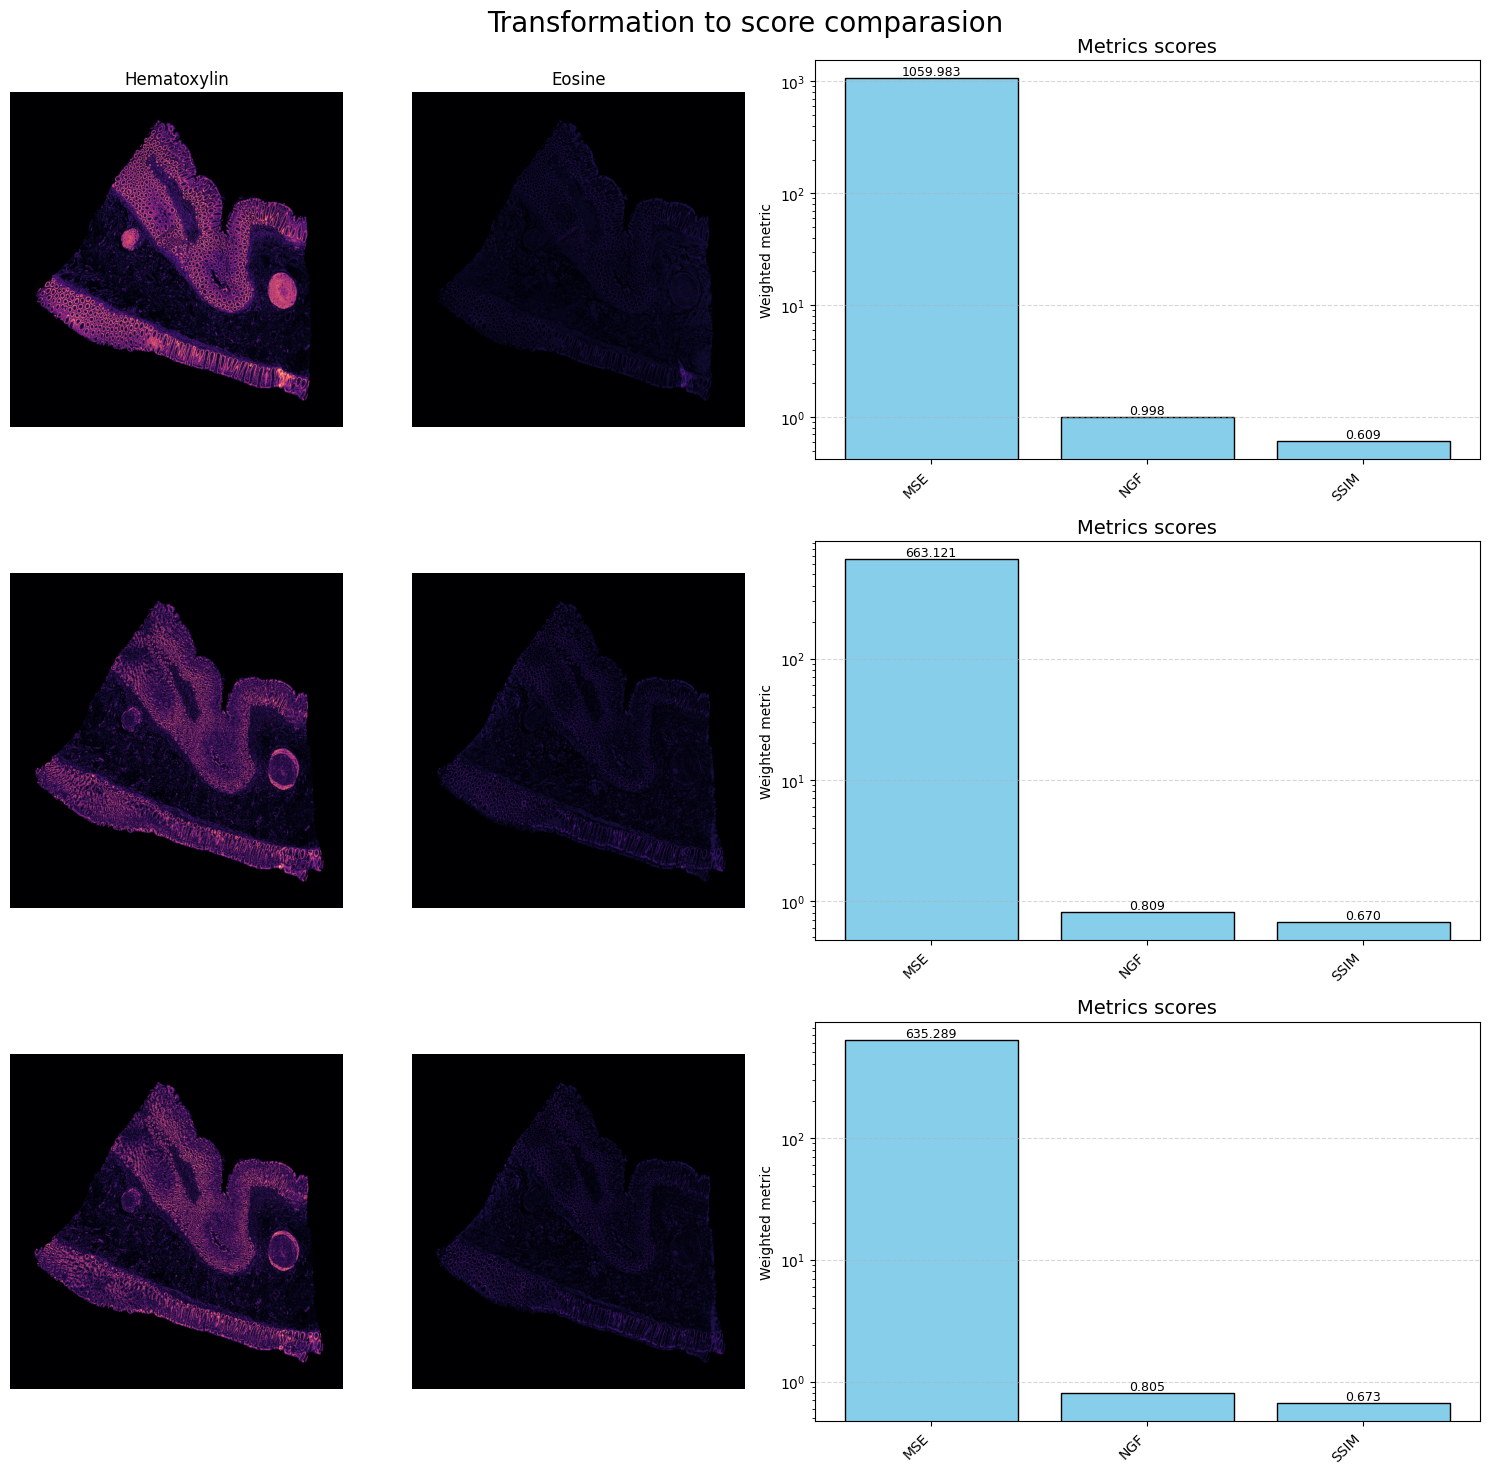

In [18]:
n = len(hyper_params)
fig, axes = plt.subplots(n, 3, figsize=(15,5*n), gridspec_kw={'width_ratios': [1, 1, 2]})
fig.suptitle('Transformation to score comparasion', fontsize=20)

if n == 1:
    axes = [axes]


axes[0,0].set_title('Hematoxylin')
axes[0,1].set_title('Eosine')
axes[0,2].set_title('Score')

for ax, s, w in zip(axes, scores, warps):
    ax[0].imshow(cv2.absdiff(w[0][...,0], w[1][...,0]), cmap='magma')
    ax[0].axis('off')
    ax[1].imshow(cv2.absdiff(w[0][...,1], w[1][...,1]), cmap='magma')
    ax[1].axis('off')
    plot_score(s, ax[2])

plt.tight_layout()
plt.show()

**Figure:** Evaluation of tissue registration quality using NGF, SSIM, and MSE across three examples of diffrent alignment. The metrics capture both geometric alignment and intensity differences, illustrating progressive degradation in registration quality, making them great fit for evaluation.

### Opimalization helper functions

Below there is a set of functions helping to combine registration function with OPTUNA optimalization pipeline.

In [19]:
def remove_prefix(s, prefix):
    s_lower = s.lower()
    prefix_lower = prefix.lower()
    
    if s_lower.startswith(prefix_lower):
        rest = s[len(prefix):]
        rest = rest.lstrip('_')
        return rest
    return s

def build_feature(params):
    features = {
        'AKAZE': cv2.AKAZE_create,
        'KAZE': cv2.KAZE_create,
        'BRISK': cv2.BRISK_create,
        'SIFT': cv2.SIFT_create,
    }
    
    feature_type = params['feature_type'].upper()
    
    if feature_type not in features.keys():
        raise ValueError('Unsupported feature: {}!'.format(feature_type))
    
    feature = features[feature_type]
    feature_params = {}
    for param, value in params.items():
        if param.upper().startswith(feature_type):
            feature_params[remove_prefix(param, feature_type)] = value

    return feature(**feature_params)

def build_matcher(params):
    matchers = ['FLANN', 'BF']
    matcher_type = params['matcher_type'].upper()

    if matcher_type not in matchers:
        raise ValueError('Unsupported matcher: {}!'.format(matcher_type))
    
    matcher_params = {}

    for param, value in params.items():
        if param.upper().startswith(matcher_type):
            matcher_params[remove_prefix(param, matcher_type)] = value

    if matcher_type == 'FLANN':
        return cv2.FlannBasedMatcher({
            'algorithm': matcher_params.pop('algorithm', 1),
            'trees': matcher_params.pop('trees', 5)
        },{
            'checks': matcher_params.pop('checks', 50)
        })
    
    return cv2.BFMatcher(**matcher_params)

def choice_to_params(choice_params):
    feature = build_feature(choice_params)
    matcher = build_matcher(choice_params)
    
    return {
        'feature':                              feature,
        'matcher':                              matcher,
        'levels':                               choice_params['levels'],
        'filter__mutual':                       choice_params['filter__mutual'],
        'filter__lowes_ratio':                  choice_params['filter__lowes_ratio'],
        'filter__weight_function':              w_function[choice_params['filter__weight_function']],
        'filter__sample_prc':                   choice_params['filter__sample_prc'],
        'homography__ransacReprojThreshold':    choice_params['homography__ransacReprojThreshold'],
        'homography__refineIters':              choice_params['homography__refineIters'],
    }

### Selection

`choice_hyper_params` function is the function is the main utility for assembling all hyperparameters used in the feature detection and matching process. It first selects a feature extractor and matcher combination via `choice_feature_matcher`, then defines additional filtering and homography parameters such as Lowe’s ratio test threshold, mutual filtering, sampling percentage, and RANSAC refinement settings. Finally, it merges all these values into a single dictionary that contains both the feature extractor parameters and matcher settings, making it suitable for systematic hyperparameter optimization with Optuna.

In [20]:
def choice_feature(trial, feature_type):
    if feature_type == 'AKAZE':
        trial.set_user_attr('AKAZE_descriptor_type', cv2.AKAZE_DESCRIPTOR_MLDB)
        feature_params = dict(
            descriptor_type=        cv2.AKAZE_DESCRIPTOR_MLDB,
            descriptor_size=        trial.suggest_int('AKAZE_descriptor_size', 0, 64),
            descriptor_channels=    trial.suggest_int('AKAZE_descriptor_channels', 1, 4),
            threshold=              trial.suggest_float('AKAZE_threshold', 0.0005, 0.01),
            nOctaves=               trial.suggest_int('AKAZE_nOctaves', 1, 8),
            nOctaveLayers=          trial.suggest_int('AKAZE_nOctaveLayers', 1, 8) 
        )
        norm_type = cv2.NORM_HAMMING
        descriptor_type = 'binary'

    elif feature_type == 'BRISK':
        feature_params = dict(
            thresh=                 trial.suggest_int('BRISK_thresh',30, 70),
            octaves=                trial.suggest_int('BRISK_octaves',1, 5),
            patternScale=           trial.suggest_float('BRISK_patternScale',0.5, 1.5, step=0.01)
        )
        norm_type = cv2.NORM_HAMMING
        descriptor_type = 'binary'

    elif feature_type == 'SIFT':
        feature_params = dict(
            nfeatures=              trial.suggest_int('SIFT_nfeatures',200, 500),
            contrastThreshold=      trial.suggest_float('SIFT_contrastThreshold',0.02, 0.08, step=0.001),
            edgeThreshold=          trial.suggest_int('SIFT_edgeThreshold',5, 20),
            sigma=                  trial.suggest_float('SIFT_sigma',1.2, 2.0, step=0.01)
        )
        norm_type = cv2.NORM_L2
        descriptor_type = 'float'

    elif feature_type == 'KAZE':
        feature_params = dict(
            upright=                trial.suggest_categorical('KAZE_upright', [True, False]),
            threshold=              trial.suggest_float('KAZE_threshold', 0.0005, 0.01),
            nOctaves=               trial.suggest_int('KAZE_nOctaves', 1, 8),
            nOctaveLayers=          trial.suggest_int('KAZE_nOctaveLayers', 1, 8),
            diffusivity=            trial.suggest_categorical(
                                        'KAZE_diffusivity',
                                        [cv2.KAZE_DIFF_PM_G1, cv2.KAZE_DIFF_PM_G2, cv2.KAZE_DIFF_WEICKERT, cv2.KAZE_DIFF_CHARBONNIER]
                                    )
        )
        norm_type = cv2.NORM_L2
        descriptor_type = 'float'

    else:
        raise ValueError("Unsupported feature type: {}!".format(feature_type))
    
    feature_params = {f'{feature_type}_{k}': v for k, v in feature_params.items()}
    feature_params['feature_type'] = feature_type

    return feature_params, norm_type, descriptor_type

def choice_matcher(trial, norm_type, descriptor_type):
    if descriptor_type == 'float':
        trial.set_user_attr('FLANN_algorithm', 1)
        matcher_params = dict(
            algorithm=              1,
            trees=                  trial.suggest_int('FLANN_trees', 1, 8),
            checks=                 trial.suggest_int('FLANN_checks', 30, 80)
        )
    else:
        trial.set_user_attr('BF_normType', norm_type)
        trial.set_user_attr('BF_crossCheck', False)
        matcher_params = dict(
            normType=               norm_type,
            crossCheck=             False
        )

    matcher_type = 'FLANN' if descriptor_type == 'float' else 'BF'
    matcher_params = {f'{matcher_type}_{k}': v for k, v in matcher_params.items()}
    matcher_params['matcher_type'] = matcher_type
    trial.set_user_attr('matcher_type', matcher_type)

    return matcher_params


def choice_feature_matcher(trial):
    features = ['AKAZE', 'BRISK', 'SIFT', 'KAZE']
    feature_type = trial.suggest_categorical('feature_type', features)

    feature, norm_type, descriptor_type = choice_feature(trial, feature_type)
    matcher = choice_matcher(trial, norm_type, descriptor_type)

    return feature, matcher

def choice_hyper_params(trial):
    feature, matcher = choice_feature_matcher(trial)
    
    params = dict(
        levels=                                 [0, 1, 2, 3, 4],
        filter__mutual=                         trial.suggest_categorical('filter__mutual',[True, False]),
        filter__lowes_ratio=                    trial.suggest_float('filter__lowes_ratio',0.6, 0.85, step=0.01),
        filter__weight_function=                trial.suggest_categorical('filter__weight_function',['power', 'linear']),
        filter__sample_prc=                     trial.suggest_float('filter__sample_prc', 0.6, 1.0, step=0.01),
        homography__ransacReprojThreshold=      trial.suggest_float('homography__ransacReprojThreshold', 0, 10.0, step=0.01),
        homography__refineIters=                trial.suggest_int('homography__refineIters', 0, 6),
    )

    params.update(feature)
    params.update(matcher)

    return params

### Optimalization and Validation

Optimization is performed on the slide with index `train_slide_index` and validated on `validate_slide_index`. The process starts with 25 random trials to broadly explore the search space and avoid premature convergence. Afterwards, 50 additional trials are executed using the NSGA-II algorithm. It is a powerful multi-objective evolutionary method that balances exploration and exploitation, allowing for an efficient search of diverse high-quality solutions across the parameter space.

In [21]:
train_slide_index = 1
validate_slide_index = 0
trials_seed = 2

nsgaii_trials = 50
random_trials = 25

load_params = 'optun_2025-07-18_20-39-19.json'  # None # If load params is None then optimalization is performed

The training and validation pipeline is straightforward: first, Optuna selects a set of parameters, then image registration is performed and a score is computed. If registration fails, the worst possible score is returned to penalize that trial. In each iteration, the parameters are updated according to Optuna’s optimization strategy, gradually guiding the search toward better-performing configurations.

In [22]:
def optuna_optimize(trial):
    choice_params = choice_hyper_params(trial)
    hyper_params = choice_to_params(choice_params)

    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slides[train_slide_index])):
        try:
            score, _ = measure_params(
                train_slide_index,
                j-1,j,
                hyper_params
            )
            avg_score = [avg_s + s for avg_s, s in zip(avg_score, score.values())]
            count += 1
        except Exception as e:
            print(f'Warning: Parameters failed !')
            print(f'Error message: {e}')
            return [np.inf, np.inf, -np.inf]

    trial.set_user_attr('params', choice_params)
    avg_score = [score / count for score in avg_score]
    return avg_score

def validate(hyper_params, plot=True):
    slide_valid = slides[validate_slide_index]

    if plot:
        n = len(slide_valid)-1
        fig, axes = plt.subplots(n, 3, figsize=(15,5*n), gridspec_kw={'width_ratios': [1, 1, 2]})
        
        if n == 1:
            axes = axes.reshape(1, -1)

    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slide_valid)):
        try:
            scores, w = measure_params(
                validate_slide_index,
                j-1,j,
                hyper_params
            )
            avg_score = [avg_s + s for avg_s, s in zip(avg_score, scores.values())]
            count += 1

            if plot:
                axes[j-1,0].imshow(cv2.absdiff(w[0][...,0], w[1][...,0]), cmap='magma')
                axes[j-1,0].axis('off')
                axes[j-1,1].imshow(cv2.absdiff(w[0][...,1], w[1][...,1]), cmap='magma')
                axes[j-1,1].axis('off')
                plot_score(scores, axes[j-1,2])
        except Exception as e:
            print(f'Validation failed !')
            print(f'Error message: {e}')
            return -np.inf

    avg_score = [score / count for score in avg_score]
    
    if plot:
        fig.suptitle('Validation of hyper parameter optimalization', fontsize=20)
        plt.tight_layout()
        plt.show()

    return avg_score

### Random Search

TODO

In [ ]:
if load_params is None:
    study = optuna.create_study(
        sampler=RandomSampler(seed=trials_seed), 
        directions=["minimize", "minimize", "maximize"]
    )

    best_params_choice = None

    study.optimize(optuna_optimize, n_trials=random_trials)

    def score_trial(trial):
        mse, ngf, ssim = trial.values
        return 0.7 * mse + 0.2 * ngf - 0.2 *  ssim

    best_trial = min(study.best_trials, key=score_trial)

    print("Best scores:", best_trial.values)
    print("Best params:", best_trial.user_attrs['params'])

In [24]:
if load_params is None:
    best_choice_hyper_params = best_trial.user_attrs['params']
    hyper_params = choice_to_params(best_choice_hyper_params)

    validate(hyper_params, True)

### Search using NSGA-II algorithm

TODO

In [ ]:
if load_params is None:


    study.sampler = NSGAIISampler(seed=trials_seed)
    study.optimize(optuna_optimize, n_trials=nsgaii_trials)

    best_trial = min(study.best_trials, key=score_trial)

    print("Best scores:", best_trial.values)
    print("Best params:", best_trial.user_attrs['params'])

In [26]:
if load_params is None:
    choice_hyper_params = best_trial.user_attrs['params']
    hyper_params = choice_to_params(choice_hyper_params)

    validate(hyper_params, True)

In [ ]:
if load_params is None:
    plot_optimization_history(study, target=score_trial, target_name='Combined score').show()
    plot_param_importances(study).show()

### Save parameters

Parameters are saved to json file with the date and time of training end.

In [ ]:
if load_params is None:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"optun_{timestamp}.json"

    save = '../data/' + filename

    with open(save, "w") as f:
        best_result = {
            "score": best_trial.values,
            "params": choice_hyper_params
        }

        json.dump(best_result, f, indent=4)

## Transform samples

Code below transforms samples according to transformations found by algorithm with optimal parameters.

In [29]:
if load_params is not None:
    with open('../data/' + load_params, 'r', encoding='utf-8') as f:
        hyper_params = choice_to_params(json.load(f)['params'])


def warp_ch(img, shape, H):
    warp = lambda ch, shape, H: cv2.warpAffine(
        ch, H, (shape[1], shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )

    if len(img.shape) < 3:
        return warp(img, shape, H)

    return np.dstack([warp(img[...,i], shape, H) for i in range(img.shape[2])])

affine_slides = []

to_dict = lambda he,m: {'he':he,'mask':m}

for slide_i, tissue_slide in enumerate(slides):
    affine_slides.append([to_dict(tissue_slide[0].he,tissue_slide[0].mask)])
    bior1, masks1 = he_bior_pyramid(tissue_slide[0], 5)
    
    print('Slide: {}'.format(slide_i))
    for i in range(1, len(tissue_slide)):
        bior2, masks2 = he_bior_pyramid(tissue_slide[i], 5)
        tissue1 = tissue_slide[i-1]
        tissue2 = tissue_slide[i]
        print('Fixed shape {} <= Moving shape {}'.format(tissue1.he.shape, tissue2.he.shape))

        H, params = find_homography_he_bior(
            bior2, bior1, 
            masks2, masks1, 
            verbose = 0,
            filter__random_seed = 0,
            return__params= True,
            **hyper_params
        )

        tissue2.he = warp_ch(tissue_slide[i].he, tissue_slide[i-1].he.shape, H)
        tissue2.mask = warp_ch(tissue_slide[i].mask.astype(np.uint8), tissue_slide[i-1].mask.shape, H).astype(bool)

        bior1, masks1 = he_bior_pyramid(tissue2, 5)

        print('After alignment: {}\n'.format(tissue2.he.shape))

        affine_slides[slide_i].append(to_dict(tissue2.he, tissue2.mask))

Slide: 0
Fixed shape (2239, 2059, 2) <= Moving shape (2239, 1992, 2)
After aligment: (2239, 2059, 2)

Fixed shape (2239, 2059, 2) <= Moving shape (2223, 1992, 2)
After aligment: (2239, 2059, 2)

Slide: 1
Fixed shape (2272, 2075, 2) <= Moving shape (2239, 2009, 2)
After aligment: (2272, 2075, 2)

Fixed shape (2272, 2075, 2) <= Moving shape (2239, 1959, 2)
After aligment: (2272, 2075, 2)

Fixed shape (2272, 2075, 2) <= Moving shape (2007, 1992, 2)
After aligment: (2272, 2075, 2)



## Save notebook results

At the end transformed tissue samples are saved for next pipeline processing.

In [ ]:
save_path = '../data/'

for i, (slide, affine_slide) in enumerate(zip(slides,affine_slides)):
    for j in range(len(slide)):
        slide[j].he = affine_slide[j]['he']
        slide[j].mask = affine_slide[j]['mask']
    
    with open(save_path + f'slide_affine_{i+1}.pkl', 'wb') as f:
        pickle.dump(slide, f)